# MY NOTEBOOK

## CONFIG

In [1]:
%load_ext autoreload
%autoreload
%reload_ext autoreload

### Imports

In [2]:
# Is this useful ? >> I think yes to avaoid taking all ressources available from the 4 GPUs
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
#import os
import fnmatch
import re
import random
import time
from datetime import datetime
import sys
import warnings

import librosa
import tensorflow as tf

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

import itertools

#import progressbar
from tqdm import tqdm_notebook as tqdm
from time import sleep

In [4]:
from models import *
from tools import *
from loading import * 
from labels_analysis import *
from train import *

## Constants

### Local Machine

In [5]:
MTT_DIR = "../MTT/"
DATA_DIRECTORY = MTT_DIR + "dataset/"
WAV_DIRECTORY = MTT_DIR + "wav-dataset/"

# CSV containing song details (title, artist, id, mp3_path,...)
CLIP_INFO_FINAL = "clip_info_final.csv"
# CSV containg the labels (clip_id, labels, mp3_path)
ANNOTATIONS_FINAL = "annotations_final.csv"
# CSV : what is it useful for ?
COMPARISONS_FINAL = "comparisons_final.csv"
LABELS_FILE = MTT_DIR + ANNOTATIONS_FINAL

LOGDIR = "checkpoints/"

DIRECTORIES = {'mp3_dir':DATA_DIRECTORY,
               'wav_dir':WAV_DIRECTORY,
               'logdir':LOGDIR,
               'labels_file':LABELS_FILE}

### LTS2 Server

This cell defines all the needed data paths, when running on LTS2 server.
Don't run this cell if you are not running the jupyter notebook on the LTS2 server ! (will overwrite the variables defined on the cell above).

You can either create a cell with your own paths, or modify the cell above with your custom paths.

In [6]:
MTT_DIR = "/mnt/scratch/students/jjgweber-MagnaTagATune/"
DATA_DIRECTORY = MTT_DIR + "dataset/"
WAV_DIRECTORY = MTT_DIR + "wav-dataset/"

# CSV containg the labels (clip_id, labels, mp3_path)
ANNOTATIONS_FINAL = "annotations_final.csv"

LABELS_FILE = MTT_DIR + ANNOTATIONS_FINAL

# need to create this directory on the server !!
LOGDIR = "checkpoints/"

DIRECTORIES = {'mp3_dir':DATA_DIRECTORY,
               'wav_dir':WAV_DIRECTORY,
               'logdir':LOGDIR,
               'labels_file':LABELS_FILE}

### Data

In [7]:
FILE_NB = 25880 #25863
FILE_LENGTH = 465984

# 465984 = 2 × 2 × 2 × 2 × 2 × 2 × 3 × 3 × 809
# useful for batches > for now divide by 9 (instead of 10)

BATCH_NB = 9
BATCH_SIZE = int(FILE_LENGTH/BATCH_NB)
SAMPLE_SIZE = 0
SAMPLE_RATE = 16000
RECEPTIVE_FIELD = 0

TRAIN_DIR = "0123456789abcde"
TEST_DIR ="f"

BASIC_CONFIG ={'numOutputNeurons':500}
LEARNING_RATE = 0.001



In [8]:
# Variables which are often modified to test the algorithm
NB_SONGS = 20
GROUP_SIZE = 20
EPOCHS = 16 # check in paper
LABELS_NAME = ['guitar', 'techno']
NB_LABELS = len(LABELS_NAME)

# use for post-processing > merge predictions of the 9 pieces by majority vote
threshold_tag = 0.7
majority = 9

In [47]:
BASIC_CONFIG = {'numOutputNeurons':500,
               'nb_batch':9,
               'batch_size':int(FILE_LENGTH/BATCH_NB),
               'tr_sample_size':60,
               'tr_group_size':20,
               'sample_rate':None,
               'train_dir':'0123456789abc',
               'test_dir':'def',
               'te_sample_size':60,
               'te_group_size':20,
               'learning_rate':0.001,
               'epochs':15,
               'labels_name':['piano', 'rock'],
               'nb_labels':2,
               'file_type':'mp3',
               'max_checkpoints':5,
               'checkpoint_every':50}


## Prediction labels

### Load and clean

In [10]:
labels, header = load_and_clean_labels(LABELS_FILE)
#labels.head(5)

/home/jjgweber/pds/loading.py:221: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels = pd.read_csv(labels_path, sep = '"\t"')


Loading csv file : 2.72


### Analyse the dataset

In [11]:
nb_labels_per_song, nb_song_per_label, label_header_by_freq = label_stats(labels, header, plot=False)

Number of songs :  25863
Number of labels :  188
Max number of songs tagged with the same label :  4852
Max number of labels for a single song :  27


In [12]:
best_10_labels = label_header_by_freq[:10]
best_30_labels = label_header_by_freq[:30]

### Co-occurence matrix


label_header_with_count: ['guitar (4852)', 'classical (4272)', 'slow (3547)', 'techno (2954)', 'strings (2729)', 'drums (2598)', 'electronic (2519)', 'rock (2371)', 'fast (2306)', 'piano (2056)']


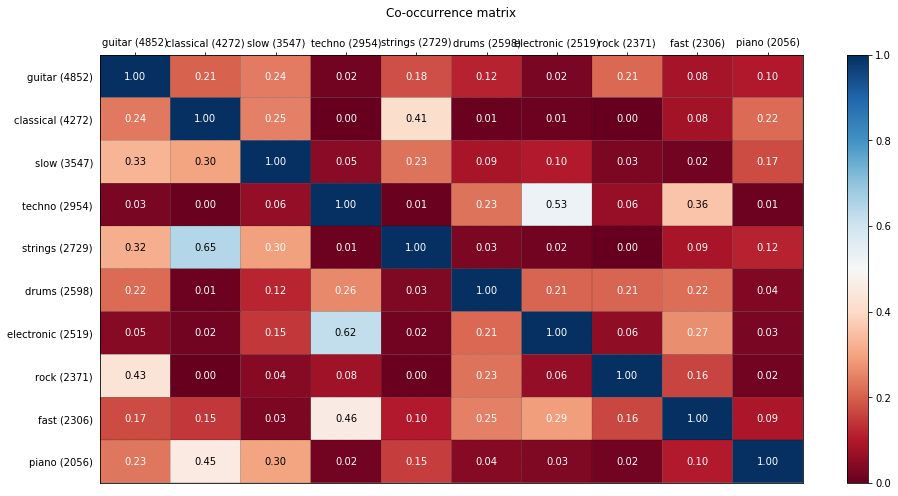

In [13]:
chosen_labels = best_10_labels
check_overlaps(chosen_labels, labels.loc[:,chosen_labels].values.astype(int))

## Load and format mp3 data

## Neural network

### Training

In [14]:
# training variables 
TRAIN_DIR = "0123456789abc"
TEST_DIR = "def"
EPOCHS = 10
BATCH_NB = 9
BATCH_SIZE = int(FILE_LENGTH/BATCH_NB)
#LOGDIR =
#LABELS_NAME = ['guitar', 'techno']
LABELS_NAME = ['piano', 'rock']
NB_LABELS = len(LABELS_NAME)
LEARNING_RATE = 0.001
GROUP_SIZE = 10
SAMPLE_SIZE = 50

In [15]:
data_dir, pattern, file_type = return_params_mp3_wav("mp3", DATA_DIRECTORY, WAV_DIRECTORY)
# also need labels but computed above

In [16]:
# FROM WAVENETS
def save(saver, sess, logdir, step):
    model_name = 'model.ckpt'
    checkpoint_path = os.path.join(logdir, model_name)
    print('Storing checkpoint to {} ...'.format(logdir), end="")
    sys.stdout.flush()

    if not os.path.exists(logdir):
        os.makedirs(logdir)

    saver.save(sess, checkpoint_path, global_step=step)
    print(' Done.')
    

def get_default_logdir(logdir_root):
    STARTED_DATESTRING = "{0:%Y-%m-%dT%H-%M-%S}".format(datetime.now())
    logdir = os.path.join(logdir_root, 'train', STARTED_DATESTRING)
    return logdir


def load(saver, sess, logdir):
    print("Trying to restore saved checkpoints from {} ...".format(logdir),
          end="")

    ckpt = tf.train.get_checkpoint_state(logdir)
    if ckpt:
        print("  Checkpoint found: {}".format(ckpt.model_checkpoint_path))
        global_step = int(ckpt.model_checkpoint_path
                          .split('/')[-1]
                          .split('-')[-1])
        print("  Global step was: {}".format(global_step))
        print("  Restoring...", end="")
        saver.restore(sess, ckpt.model_checkpoint_path)
        print(" Done.")
        return global_step
    else:
        print(" No checkpoint found.")
        return None

In [17]:
def initialize_tf_model(input_shape, nb_labels, nb_batch, batch_size, learning_rate, is_training=True) :
    print("Initialize tf model ...")
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, shape=(input_shape*nb_batch, batch_size, 1))
    y = tf.placeholder(tf.float32, shape=(input_shape*nb_batch, nb_labels))

    net = build_model(x, is_training=is_training, config=BASIC_CONFIG) 
    predictions = tf.layers.dense(net, nb_labels, activation=tf.sigmoid)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = predictions)
    reduced_loss = tf.reduce_mean(loss)
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(reduced_loss)
    auc = tf.metrics.auc(labels = y, predictions=predictions)
    
    # Saver for storing checkpoints of the model. (Wavenets)
    saver = tf.train.Saver(var_list=tf.global_variables())
    
    return x, y, net, predictions, loss, reduced_loss,  train_op, auc, saver

In [33]:
def train_restore(config, directories, labels, restore=False, restore_from=None) : 
    
    # EXTRACT CONFIG VARIABLES
    #data_dir = directories['data_dir']
    logdir_root = directories['logdir']
    
    group_size = config['tr_group_size']
    sample_size = config['tr_sample_size']
    file_type = config['file_type']
    train_dir = config['train_dir']
    epochs = config['epochs']
    labels_name = config['labels_name']
    nb_labels = config['nb_labels']
    batch_size = config['batch_size']
    nb_batch = config['nb_batch']
    learning_rate = config['learning_rate']
    
    # PARAMETER CHECK
    if restore and restore_from is None :
        raise ValueError("You need to specify the checkpoint to restore from"
                         "if restore is True.")
    
    # CREATE CHECKPOINT DIRECTORY
    logdir = get_default_logdir(logdir_root)
    print('Using default logdir: {}'.format(logdir))            
            
    # LOSS AND AUC RESULTS
    train_loss_results = []
    train_auc_results = []

    # GET NAME OF FILES FOR SONGS TO LOAD
    # use find_files_group_select which filters songs 
    # which have at least one of the labels and create groups
    files_by_group = find_files_group_select(data_dir, labels, labels_name, group_size, sample=sample_size, \
                                             pattern=pattern, sub_dir=train_dir)
    
    n_groups = len(files_by_group)

    # INITIALIZE TF MODEL (VARIABLES)
    x, y, net, predictions, loss, reduced_loss, \
    train_op, auc, _ = initialize_tf_model(len(files_by_group[0]), nb_labels, nb_batch,\
                                               batch_size, learning_rate)
    
    # TRAINING
    print("Start training...")

    start = time.time()

    with tf.Session() as sess:

        # INITIALIZE SESSION AND ADAPT IF RESTORING
        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

        sess.run(init)
            
        # Saver for storing checkpoints of the model.
        saver = tf.train.Saver(var_list=tf.global_variables(), max_to_keep=config['max_checkpoints'])

        last_saved_step = -1
        # The first training step will be saved_global_step + 1,
        # therefore we put -1 here for new or overwritten trainings.
        saved_global_step = -1        
        
        if restore :
            try:
                # compute number of epochs left
                saved_global_step = load(saver, sess, restore_from)
                last_saved_step = saved_global_step

            except:
                print("Something went wrong while restoring checkpoint. "
                      "We will terminate training to avoid accidentally overwriting "
                      "the previous model.")
                raise


        # START TRAINING
        epoch = 0        
        try:
            for epoch in tqdm(range(saved_global_step + 1,  config['epochs'])):

                t0_epoch = time.time()
                loss_values = []
                auc_results = []

                # Feed songs to the network group by group
                for count, g in enumerate(files_by_group) :
                    
                    # Load audio and labels
                    tload0 = time.time()
                    audios, tags = load_audio_label_aux(labels, g, len(data_dir), labels_name=labels_name, \
                            nb_labels=nb_labels, file_type=file_type, batch_size=batch_size, nb_batch=nb_batch)

                    tload1 = time.time()
                    if count==0 :
                        print(">> Total loading time : {:.2f} sec".format(tload1-tload0))

                    # Feed to network and get metrics
                    predict, _, loss_value, auc_score = sess.run([predictions, train_op, reduced_loss, auc],\
                                                                 feed_dict={x: audios, y: tags})

                    auc_result, update_op = auc_score

                    # Save loss and auc values
                    loss_values.append(loss_value)
                    auc_results.append(auc_result)

                    if (count % 20) == 0 :
                        print("Group {} done. {} left.".format(count, n_groups-count-1))

                        
                train_loss_results.append(loss_values)
                train_auc_results.append(auc_results)
                
                dur = time.time()-t0_epoch

                print("Epoch: {:3}, Time (in sec): {:.2f}, Loss: {:.4f}, AUC : {:.4f}"\
                      .format(epoch, dur, loss_value, auc_result))
                print()

                # Save network state periodically
                if epoch % config['checkpoint_every'] == 0:
                    save(saver, sess, logdir, epoch)
                    last_saved_step = epoch

        except KeyboardInterrupt:
            # Introduce a line break after ^C is displayed so save message
            # is on its own line.
            print()

        finally:
            if epoch > last_saved_step:
                save(saver, sess, logdir, epoch)
            
            duration2 = time.time()-start
            print("Total time: {:.2f} minutes.".format(duration2/60))

    return train_loss_results, train_auc_results

In [40]:
def flatten_loss_auc_results(train_loss_results, train_auc_results):
    return [e for l in train_loss_results for e in l], [e for l in train_auc_results for e in l]

In [30]:
def average_loss_auc_results(train_loss_results, train_auc_results):
    return [sum(l) / len(l) for l in train_loss_results], [sum(l) / len(l) for l in train_auc_results]

In [31]:
train_loss_results, train_auc_results = train_restore(BASIC_CONFIG, DIRECTORIES, labels)

Using default logdir: checkpoints/train/2019-06-02T17-42-38
All labels : 25863 songs >>> Selected for given labels : 4387. (test or train sets are note taken    into account here)
Initialize tf model ...
Start training...


>> Total loading time : 8.24 sec
Group 0 done. 2 left.
Epoch:   0, Time (in sec): 27.60, Loss: 0.5739, AUC : 0.7505

Storing checkpoint to checkpoints/train/2019-06-02T17-42-38 ... Done.
>> Total loading time : 8.68 sec
Group 0 done. 2 left.
Epoch:   1, Time (in sec): 27.40, Loss: 0.5558, AUC : 0.9019

>> Total loading time : 8.44 sec
Group 0 done. 2 left.
Epoch:   2, Time (in sec): 27.11, Loss: 0.5416, AUC : 0.9243

>> Total loading time : 8.57 sec
Group 0 done. 2 left.
Epoch:   3, Time (in sec): 27.08, Loss: 0.5326, AUC : 0.9364

>> Total loading time : 8.71 sec
Group 0 done. 2 left.
Epoch:   4, Time (in sec): 27.78, Loss: 0.5495, AUC : 0.9437

>> Total loading time : 8.22 sec
Group 0 done. 2 left.
Epoch:   5, Time (in sec): 26.68, Loss: 0.5410, AUC : 0.9458

>> Total loading time : 8.74 sec
Group 0 done. 2 left.
Epoch:   6, Time (in sec): 27.25, Loss: 0.5558, AUC : 0.9494

>> Total loading time : 8.81 sec
Group 0 done. 2 left.
Epoch:   7, Time (in sec): 27.44, Loss: 0.5343, AUC : 0.

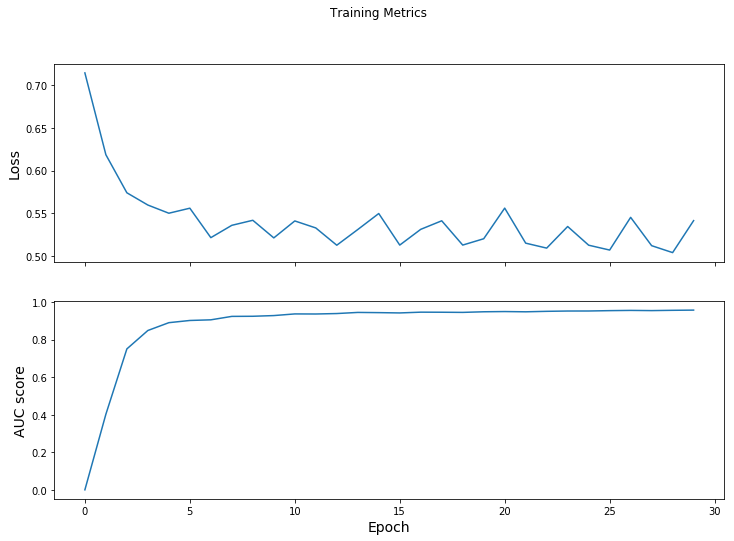

In [41]:
flat = flatten_loss_auc_results(train_loss_results, train_auc_results)
plot_auc_loss(flat[0], flat[1])

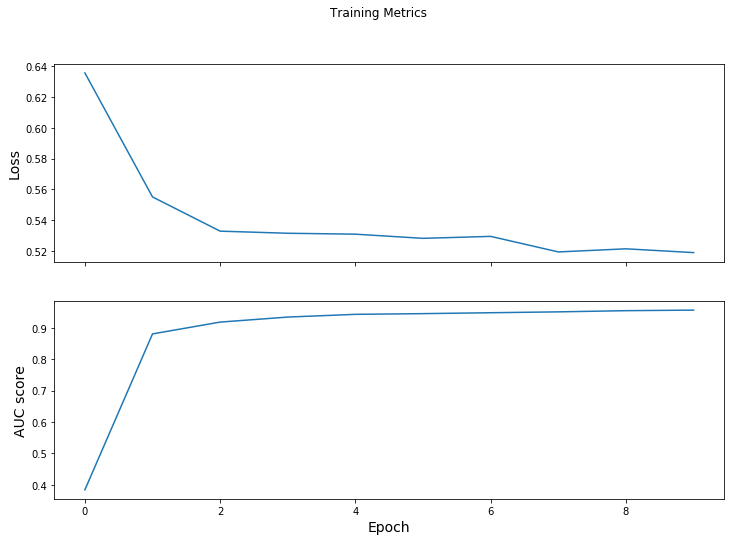

In [38]:
avg = average_loss_auc_results(train_loss_results, train_auc_results)
plot_auc_loss(avg[0], avg[1])

In [43]:
train_loss_results2, train_auc_results2 = train_restore(BASIC_CONFIG, DIRECTORIES, labels, restore=True, \
                                                       restore_from = "checkpoints/train/2019-06-02T17-42-38")

Using default logdir: checkpoints/train/2019-06-02T17-55-50
All labels : 25863 songs >>> Selected for given labels : 4387. (test or train sets are note taken    into account here)
Initialize tf model ...
Start training...
Trying to restore saved checkpoints from checkpoints/train/2019-06-02T17-42-38 ...  Checkpoint found: checkpoints/train/2019-06-02T17-42-38/model.ckpt-9
  Global step was: 9
  Restoring...INFO:tensorflow:Restoring parameters from checkpoints/train/2019-06-02T17-42-38/model.ckpt-9
 Done.


>> Total loading time : 8.34 sec
Group 0 done. 2 left.
Epoch:  10, Time (in sec): 27.37, Loss: 0.5336, AUC : 0.9785

>> Total loading time : 8.34 sec
Group 0 done. 2 left.
Epoch:  11, Time (in sec): 26.94, Loss: 0.5386, AUC : 0.9726

>> Total loading time : 8.63 sec
Group 0 done. 2 left.
Epoch:  12, Time (in sec): 27.39, Loss: 0.5272, AUC : 0.9711

>> Total loading time : 8.06 sec
Group 0 done. 2 left.
Epoch:  13, Time (in sec): 26.05, Loss: 0.5300, AUC : 0.9717

>> Total loading time : 8.42 sec
Group 0 done. 2 left.
Epoch:  14, Time (in sec): 27.07, Loss: 0.5279, AUC : 0.9721

Storing checkpoint to checkpoints/train/2019-06-02T17-55-50 ... Done.
Total time: 0.38 hours.


In [ ]:
def train(data_dir, group_size, sample_size, file_type, train_dir, epochs, \
          labels, labels_name, nb_labels, batch_size, nb_batch, logdir, learning_rate) :
    
    pattern = ""
    if file_type == "mp3" :
        pattern = "*.mp3"
    else :
        if file_type == "wav" :
            pattern = "*.wav"
        else :
            print("Argument should be either \"mp3\" or \"wav\".")
        
    # keep results for plotting
    train_loss_results = []
    train_auc_results = []


    files_by_group = find_files_group_select(data_dir, labels, labels_name, group_size, sample=sample_size, \
                                             pattern=pattern, sub_dir=train_dir)
    
    n_groups = len(files_by_group)
    #print(data_dir, labels, labels_name, group_size)

    x, y, net, predictions, loss, reduced_loss, \
    train_op, auc, saver = initialize_tf_model(len(files_by_group[0]), nb_labels, nb_batch,\
                                               batch_size, learning_rate)
    print("Start training...")

    start = time.time()

    with tf.Session() as sess:

        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

        sess.run(init)

        try :
            # Go through the whole DS at each EPOCH
            for epoch in tqdm(range(epochs)):

                t0_epoch = time.time()

                # Group by group
                for count, g in enumerate(files_by_group) :

                    # Load audio and labels
                    tload0 = time.time()
                    audios, tags = load_audio_label_aux(labels, g, len(data_dir), labels_name=labels_name, \
                            nb_labels=nb_labels, file_type=file_type, batch_size=batch_size, nb_batch=nb_batch)

                    tload1 = time.time()

                    if count==0 :
                        print(">> Total loading time : {:.2f} sec".format(tload1-tload0))
                    #audio_tf = tf.convert_to_tensor(audios, np.float32)

                    # add check to verify if there is something to restore
                    #saver.restore(sess, LOGDIR)

                    predict, _, loss_value, auc_score = sess.run([predictions, train_op, reduced_loss, auc],\
                                                                 feed_dict={x: audios, y: tags})

                    auc_result, update_op = auc_score

                    saver.save(sess, logdir)


                    train_loss_results.append(loss_value)
                    train_auc_results.append(auc_result)

                    if (count % 20) == 0 :
                        print("Group {} done. {} left.".format(count, n_groups-count-1))


                t1_epoch = time.time()

                dur = t1_epoch-t0_epoch

                print("Iter: {:3}, Time (in sec): {:.2f}, Loss: {:.4f}, AUC : {:.4f}"\
                      .format(epoch, dur, loss_value, auc_result))
                print()
            
            
        except KeyboardInterrupt:
            # Introduce a line break after ^C is displayed so save message
            # is on its own line.
            print()

        finally:
            #if step > last_saved_step:
             #   save(saver, sess, logdir, step)
            #coord.request_stop()
            #coord.join(threads)
            
            end = time.time()
            duration2 = end-start
            print("Total time: {:.2f} sec.".format(duration2))
            
            return train_loss_results, train_auc_results


    return train_loss_results, train_auc_results

In [ ]:
def train_all(group_size) :
    train_loss_results, train_auc_results = train(data_dir, group_size, None, file_type,\
                                                  TRAIN_DIR, EPOCHS, labels, LABELS_NAME, NB_LABELS, \
                                                  BATCH_SIZE, BATCH_NB, LOGDIR, LEARNING_RATE)
    return train_loss_results, train_auc_results

In [ ]:
def train_input_shape(group_size, sample_size) :
    train_loss_results, train_auc_results = train(data_dir, group_size, sample_size, file_type,\
                                                  TRAIN_DIR, EPOCHS, labels, LABELS_NAME, NB_LABELS, \
                                                  BATCH_SIZE, BATCH_NB, LOGDIR, LEARNING_RATE)
    return train_loss_results, train_auc_results

In [ ]:
def train_labels_choice(labels_name, nb_labels) :
    train_loss_results, train_auc_results = train(data_dir, GROUP_SIZE, SAMPLE_SIZE, file_type, \
                                                  TRAIN_DIR, EPOCHS, labels, labels_name, nb_labels, \
                                                  BATCH_SIZE, BATCH_NB, LOGDIR, LEARNING_RATE)
    return train_loss_results, train_auc_results

In [ ]:
def train_learning_rate(l_rate) :
    train_loss_results, train_auc_results = train(data_dir, group_size, sample_size, file_type, \
                                                  TRAIN_DIR, EPOCHS, labels, labels_name, nb_labels, \
                                                  BATCH_SIZE, BATCH_NB, LOGDIR, l_rate)
    return train_loss_results, train_auc_results

In [ ]:
train_loss_results, train_auc_results = train_input_shape(10, 60)

In [ ]:
train_loss_results, train_auc_results = train_all(20)

In [ ]:
plot_auc_loss(train_loss_results, train_auc_results)

## Testing

In [66]:
# Validation = Testing on the train set
def validation(config, directories, labels, model_ckpt) : 
    
    # EXTRACT CONFIG VARIABLES
    #data_dir = directories['data_dir']
    logdir_root = directories['logdir']
    
    group_size = config['te_group_size']
    sample_size = config['te_sample_size']
    file_type = config['file_type']
    test_dir = config['train_dir']
    labels_name = config['labels_name']
    nb_labels = config['nb_labels']
    batch_size = config['batch_size']
    nb_batch = config['nb_batch'] 
    learning_rate = config['learning_rate']
            
    # LOSS AND AUC RESULTS
    test_loss_results = []
    test_auc_results = []

    # GET NAME OF FILES FOR SONGS TO LOAD
    # use find_files_group_select which filters songs 
    # which have at least one of the labels and create groups
    files_by_group = find_files_group_select(data_dir, labels, labels_name, group_size, sample=sample_size, \
                                             pattern=pattern, sub_dir=test_dir)
    
    n_groups = len(files_by_group)

    # INITIALIZE TF MODEL (VARIABLES)
    x, y, net, predictions, loss, reduced_loss, train_op, \
    auc, _ = initialize_tf_model(len(test_files[0]), nb_labels, nb_batch,\
                                               batch_size, learning_rate, is_training=False)
    
    variables_to_restore = { 
        var.name[:-2]: var for var in tf.global_variables() 
        if not ('state_buffer' in var.name or 'pointer' in var.name)}

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver(variables_to_restore)

    # Later, launch the model, use the saver to restore variables from disk, and
    # do some work with the model.
    with tf.Session() as sess:
        # Restore variables from disk.
        print('Restoring model from {}'.format(model_ckpt))
        saver.restore(sess, model_ckpt)
        print("Model restored.")
    
        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

        sess.run(init) 

        predicts = sess.run([predictions, train_op, reduced_loss, auc], \
                            feed_dict={x: audios_test, y: tags_test})

        # START TESTING EACH GROUP   
        try:
            t0_epoch = time.time()

            # Feed songs to the network group by group
            for count, g in enumerate(files_by_group) :

                # Load audio and labels
                tload0 = time.time()
                audios, tags = load_audio_label_aux(labels, test_files[0], len(data_dir), \
                                                    labels_name=LABELS_NAME, nb_labels=NB_LABELS, \
                                                    file_type=file_type, batch_size=BATCH_SIZE, nb_batch=BATCH_NB)

                tload1 = time.time()
                print(">> Total loading time : {:.2f} sec".format(tload1-tload0))

                # Feed to network and get metrics
                predict, _, loss_value, auc_score = sess.run([predictions, train_op, reduced_loss, auc],\
                                                             feed_dict={x: audios, y: tags})

                auc_result, update_op = auc_score

                # Save loss and auc values
                test_loss_results.append(loss_value)
                test_auc_results.append(auc_result)

                dur = time.time()-t0_epoch

                print("Group {} done. {} left.".format(count, n_groups-count-1))
                print("Time (in sec): {:.2f}, Loss: {:.4f}, AUC : {:.4f}"\
                  .format(dur, loss_value, auc_result))
                
                print()


        except KeyboardInterrupt:
            # Introduce a line break after ^C is displayed so save message
            # is on its own line.
            print()

        finally:            
            duration2 = time.time()-t0_epoch
            print("Total time: {:.2f} minutes.".format(duration2/60))

    return test_loss_results, test_auc_results

In [67]:
def testing(config, directories, labels, model_ckpt) : 
    
    # EXTRACT CONFIG VARIABLES
    #data_dir = directories['data_dir']
    logdir_root = directories['logdir']
    
    group_size = config['te_group_size']
    sample_size = config['te_sample_size']
    file_type = config['file_type']
    test_dir = config['test_dir']
    labels_name = config['labels_name']
    nb_labels = config['nb_labels']
    batch_size = config['batch_size']
    nb_batch = config['nb_batch'] 
    learning_rate = config['learning_rate']
            
    # LOSS AND AUC RESULTS
    test_loss_results = []
    test_auc_results = []

    # GET NAME OF FILES FOR SONGS TO LOAD
    # use find_files_group_select which filters songs 
    # which have at least one of the labels and create groups
    files_by_group = find_files_group_select(data_dir, labels, labels_name, group_size, sample=sample_size, \
                                             pattern=pattern, sub_dir=test_dir)
    
    n_groups = len(files_by_group)

    # INITIALIZE TF MODEL (VARIABLES)
    x, y, net, predictions, loss, reduced_loss, train_op, \
    auc, _ = initialize_tf_model(len(test_files[0]), nb_labels, nb_batch,\
                                               batch_size, learning_rate, is_training=False)
    
    variables_to_restore = { 
        var.name[:-2]: var for var in tf.global_variables() 
        if not ('state_buffer' in var.name or 'pointer' in var.name)}

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver(variables_to_restore)

    # Later, launch the model, use the saver to restore variables from disk, and
    # do some work with the model.
    with tf.Session() as sess:
        # Restore variables from disk.
        print('Restoring model from {}'.format(model_ckpt))
        saver.restore(sess, model_ckpt)
        print("Model restored.")
    
        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

        sess.run(init) 

        predicts = sess.run([predictions, train_op, reduced_loss, auc], \
                            feed_dict={x: audios_test, y: tags_test})

        # START TESTING EACH GROUP   
        try:
            t0_epoch = time.time()

            # Feed songs to the network group by group
            for count, g in enumerate(files_by_group) :

                # Load audio and labels
                tload0 = time.time()
                audios, tags = load_audio_label_aux(labels, test_files[0], len(data_dir), \
                                                    labels_name=LABELS_NAME, nb_labels=NB_LABELS, \
                                                    file_type=file_type, batch_size=BATCH_SIZE, nb_batch=BATCH_NB)

                tload1 = time.time()
                print(">> Total loading time : {:.2f} sec".format(tload1-tload0))

                # Feed to network and get metrics
                predict, _, loss_value, auc_score = sess.run([predictions, train_op, reduced_loss, auc],\
                                                             feed_dict={x: audios, y: tags})

                auc_result, update_op = auc_score

                # Save loss and auc values
                test_loss_results.append(loss_value)
                test_auc_results.append(auc_result)

                dur = time.time()-t0_epoch

                print("Group {} done. {} left.".format(count, n_groups-count-1))
                print("Time (in sec): {:.2f}, Loss: {:.4f}, AUC : {:.4f}"\
                  .format(dur, loss_value, auc_result))
                
                print()


        except KeyboardInterrupt:
            # Introduce a line break after ^C is displayed so save message
            # is on its own line.
            print()

        finally:            
            duration2 = time.time()-t0_epoch
            print("Total time: {:.2f} minutes.".format(duration2/60))

    return test_loss_results, test_auc_results

In [65]:
testing(BASIC_CONFIG, DIRECTORIES, labels, 'checkpoints/train/2019-06-02T17-55-50/model.ckpt-14')

All labels : 25863 songs >>> Selected for given labels : 4387. (test or train sets are note taken    into account here)
Initialize tf model ...
Restoring model from checkpoints/train/2019-06-02T17-55-50/model.ckpt-14
INFO:tensorflow:Restoring parameters from checkpoints/train/2019-06-02T17-55-50/model.ckpt-14
Model restored.
['/mnt/scratch/students/jjgweber-MagnaTagATune/dataset/d/katherine_roberts_perl-j_s__bach_french_suites-07-suite_no_4_in_e_flat_major_bwv_815_gigue-0-29.mp3', '/mnt/scratch/students/jjgweber-MagnaTagATune/dataset/d/sarasa_ensemble_labelle_sylvan-bach_cantatas-10-ich_habe_genug_aria-320-349.mp3', '/mnt/scratch/students/jjgweber-MagnaTagATune/dataset/d/seismic_anamoly-afterburner-07-ten_million_tears-233-262.mp3', '/mnt/scratch/students/jjgweber-MagnaTagATune/dataset/d/seth_and_maryse_carlin-schubert__music_for_fortepiano_four_hands-03-sonata_in_c_major_grand_duo__scherzo__allegro_vivace-204-233.mp3', '/mnt/scratch/students/jjgweber-MagnaTagATune/dataset/d/shira_kamm

([0.70083, 0.694145, 0.6936209], [0.33710566, 0.55114025, 0.55694634])

Following TF tutorial for custom training
https://github.com/tensorflow/docs/blob/master/site/en/tutorials/eager/custom_training_walkthrough.ipynb

# OLD STUFF

In [ ]:
data_dir, pattern, file_type = return_params_mp3_wav("mp3", DATA_DIRECTORY, WAV_DIRECTORY)
group_size, sample_size =10, 50
train(data_dir, group_size, sample_size, file_type, TRAIN_DIR, EPOCHS, labels, LABELS_NAME, NB_LABELS, \
     BATCH_SIZE, BATCH_NB, LOGDIR, LEARNING_RATE)

In [ ]:
# VERSION 2 : feed group by group
def train_v2(group_size=10, sample_size=50):

    files_by_group = find_files_group(data_dir, group_size, sample=sample_size, pattern=pattern, sub_dir=TRAIN_DIR)
    n_groups = len(files_by_group)

    x, y, net, predictions, loss, reduced_loss,  train_op, auc, saver = initialize_tf_model()

    print("Start training...")

    start = time.time()

    with tf.Session() as sess:

        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

        sess.run(init)

        # Go through the whole DS at each EPOCH
        for epoch in tqdm(range(EPOCHS)):

            t0_epoch = time.time()

            # Group by group
            for count, g in enumerate(files_by_group) :

                # Load audio and labels
                tload0 = time.time()
                audios, tags = load_audio_label_aux(labels, g, len(data_dir), labels_name=LABELS_NAME, \
                        nb_labels=NB_LABELS, file_type=file_type, batch_size=BATCH_SIZE, nb_batch=BATCH_NB)
                tload1 = time.time()

                if count==0 :
                    print(">> Total loading time : {:.2f} sec".format(tload1-tload0))
                #audio_tf = tf.convert_to_tensor(audios, np.float32)

                # add check to verify if there is something to restore
                #saver.restore(sess, LOGDIR)

                predict, _, loss_value, auc_score = sess.run([predictions, train_op, reduced_loss, auc],\
                                                             feed_dict={x: audios, y: tags})
                auc_result, update_op = auc_score

                saver.save(sess, LOGDIR)


                train_loss_results.append(loss_value)
                train_auc_results.append(auc_result)

                print("Group {} done. {} left.".format(count, n_groups-count))


            t1_epoch = time.time()

            dur = t1_epoch-t0_epoch

            print("Iter: {:3}, Time (in sec): {:.2f}, Loss: {:.4f}, AUC : {:.4f}"\
                  .format(epoch, dur, loss_value, auc_result))
            print()

        end = time.time()
        duration2 = end-start
        print("Total time: {:.2f} sec.".format(duration2))


## Load and format mp3 data 

### Loading audio & tags

In [ ]:
''' Use Example 
 load audios and labels > convert to numpy
 CAREFUL : the argument num_songs is important and shouldn't be too big 
 > otherwise MEMORY ISSUES !!!!!!

audios, tags, order, order2 = load_audio_label(cleaned, num_songs=NB_SONGS, sub_dir=TRAIN_DIR, \
                                file_type="mp3", directory=DATA_DIRECTORY, randomize_batch=True) '''

def load_audio_label(labels, num_songs, sample_rate=None, directory=WAV_DIRECTORY, \
                     labels_name=LABELS_NAME, sub_dir=None, file_type="wav", randomize_batch=False):
    
    assert (file_type=="wav" or file_type=="mp3"), "The argument file_type should be either 'wav', either 'mp3'."
    if (file_type=="wav" and directory!=WAV_DIRECTORY) or (file_type=="mp3" and directory!=DATA_DIRECTORY):
        warnings.warn("File type and directory may not correspond. Make sure the \
        directory gave as parameter contains the right type of files", FutureWarning, stacklevel=2)
        
    if num_songs > 20 :
        warnings.warn("The argument num_song should not be too high (above 20), make sure this will \
        not cause memory error.", FutureWarning, stacklevel=2)
       
    
    print("Loading data ...")
    start = time.time()
    
    if file_type=="mp3" :
        files = find_files(directory, sample=num_songs, sub_dir=sub_dir)
    if file_type=="wav" :
        files = find_files(directory, sample=num_songs, sub_dir=sub_dir, pattern='*.wav')
 
    randomized_files = randomize_files(files)
    
    count = 0
    
    audios = np.ndarray(shape=(num_songs * BATCH_NB, BATCH_SIZE, 1), dtype=np.float32, order='F')
    tags = np.ndarray(shape=(num_songs * BATCH_NB, NB_LABELS), dtype=np.float32, order='F')
    order = np.zeros(num_songs * BATCH_NB, dtype=int)
    order2 = np.zeros(num_songs * BATCH_NB, dtype=int)
    
    idx = 0
    
    for filename in randomized_files:

        # Load audio (MP3/WAV) file        
        try :
            audio, _ = librosa.load(filename, sr=sample_rate, mono=True)
        except EOFError :
            print("EOFERROR : The following file could not be loaded with librosa - ", filename)

        audio = audio.reshape(-1, 1)
         
        for n in range(BATCH_NB) :
            audios[idx] = audio[n*BATCH_SIZE: (n+1)*BATCH_SIZE,:]
            
            # take labels or corresponding song
            
            if file_type=="mp3" :
                select_labels  = labels.loc[labels['mp3_path']==filename[len(directory):]]
            
            if file_type=="wav" :
                select_labels  = labels.loc[labels['mp3_path']==filename[len(directory):-4]+".mp3"]

            # select wanted labels
            select_labels = select_labels[labels_name]

            tags[idx] = select_labels.values.reshape(NB_LABELS)
            
            order[idx] = count
            order2[idx] = idx
            idx +=1
        
        count +=1
        if (count % 10) == 0:
            print(count)
    
    if randomize_batch :
        rng_state = np.random.get_state()
        np.random.shuffle(audios)
        np.random.set_state(rng_state)
        np.random.shuffle(tags)
        np.random.set_state(rng_state)
        np.random.shuffle(order)
        np.random.set_state(rng_state)
        np.random.shuffle(order2)
        
    end = time.time()
    duration = end-start
    print(">> Total loading time - {} songs : {:.2f} sec".format(num_songs, duration))
    print()
    print("Shape of audios list :", audios.shape)
    print("Shape of tags list :", tags.shape)
    return audios, tags, order, order2

In [ ]:
# This one is not correct yet I think
def load_audio_label_prim(labels, num_songs, sample_rate=None, directory=WAV_DIRECTORY, \
                     labels_name=LABELS_NAME, sub_dir=None, file_type="wav", randomize_batch=False):
    
    
    assert (file_type=="wav" or file_type=="mp3"), "The argument file_type should be either 'wav', either 'mp3'."
    if (file_type=="wav" and directory!=WAV_DIRECTORY) or (file_type=="mp3" and directory!=DATA_DIRECTORY):
        warnings.warn("File type and directory may not correspond. Make sure the \
        directory gave as parameter contains the right type of files", FutureWarning, stacklevel=2)
        
    if num_songs > 20 :
        warnings.warn("The argument num_song should not be too high (above 20), make sure this will \
        not cause memory error.", FutureWarning, stacklevel=2)
        
    print("Loading data ...")
    start = time.time()
    
    if group_size != None:
        if file_type=="mp3" :
            files = find_files_group(directory, group_size, sample=num_songs, sub_dir=sub_dir, pattern='*.mp3')
        if file_type=="wav" :
            files = find_files_group(directory, group_size, sample=num_songs, sub_dir=sub_dir, pattern='*.wav')
    
    else :
        if file_type=="mp3" :
            files = find_files(directory, sample=num_songs, sub_dir=sub_dir, pattern='*.mp3')
        if file_type=="wav" :
            files = find_files(directory, sample=num_songs, sub_dir=sub_dir, pattern='*.wav')
            
    randomized_files = randomize_files(files)
    
    count = 0
    
    audios = np.ndarray(shape=(num_songs * BATCH_NB, BATCH_SIZE, 1), dtype=np.float32, order='F')
    tags = np.ndarray(shape=(num_songs * BATCH_NB, NB_LABELS), dtype=np.float32, order='F')
    order = np.zeros(num_songs * BATCH_NB, dtype=int)
    order2 = np.zeros(num_songs * BATCH_NB, dtype=int)
    

    
    if group_size != None :
        for group in files :
            load_audio_label_aux(cleaned, group, len(directory), labels_name=labels_name, file_type=file_type)
    
    # check where to put this after        
    if randomize_batch :
        rng_state = np.random.get_state()
        np.random.shuffle(audios)
        np.random.set_state(rng_state)
        np.random.shuffle(tags)
        np.random.set_state(rng_state)
        np.random.shuffle(order)
        np.random.set_state(rng_state)
        np.random.shuffle(order2)
        
    end = time.time()
    duration = end-start
    print(">> Total loading time - {} songs : {:.2f} sec".format(num_songs, duration))
    print()
    print("Shape of audios list :", audios.shape)
    print("Shape of tags list :", tags.shape)
    return audios, tags, order, order2

## Neural Network model

### Save neural net state tool

In [ ]:
# clean argument passing
def merge_predictions(predictions, order, num_songs = NB_SONGS, threshold=0.5, majority=5):
    print("ORD:",order)
    print(type(predictions[0]))
    #tf.map_fn(tf.invert_permutation, (predictions, order))
    ordered = tf.gather(predictions, indices=order, axis=0)
    
    new_predictions = np.zeros(num_songs * BATCH_NB, dtype= np.float32)
    
    count1 = 0
    for b in range(BATCH_NB) :
        if ordered[b] > threshold :
            count1 +=1
            
    if count1 >= majority :
        for b in range(BATCH_NB) :
            new_predictions[b] = 1
    
    return tf.convert_to_tensor(new_predictions, np.float32)

### Training

In [ ]:
# run this cell everytime before relaunching tensorflow session
tf.reset_default_graph()

In [ ]:
# VERSION 1 : DOESN'T HANDLE GROUPS - feeds all sample of given size to the network 

def train_v1() :
    
    # keep results for plotting
    train_loss_results = []
    train_auc_results = []

    print("Initializing tf model ...")

    audio_tf= tf.convert_to_tensor(audios, np.float32)
    print("Input shape : {}".format(audio_tf.shape))
    print("Labels : {}".format(tags.flatten()))
    print()

    net = build_model(audio_tf, is_training=True, config=BASIC_CONFIG) 
    predictions = tf.layers.dense(net, NB_LABELS, activation=tf.sigmoid)
    #predictions = merge_predictions(predictions, order2)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tags, logits = predictions)
    reduced_loss = tf.reduce_mean(loss)
    train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(reduced_loss)
    auc = tf.metrics.auc(labels = tags, predictions=predictions)


    # Saver for storing checkpoints of the model. (Wavenets)
    saver = tf.train.Saver(var_list=tf.global_variables())

    print("Start training...")

    start = time.time()

    with tf.Session() as sess:

        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

        sess.run(init)

        for epoch in tqdm(range(EPOCHS)):
            t0_epoch = time.time()
            predict, _, loss_value, auc_score = sess.run([predictions, train_op, reduced_loss, auc])
            #print(type(predict))
            auc_result, update_op = auc_score

            train_loss_results.append(loss_value)
            train_auc_results.append(auc_result)

            t1_epoch = time.time()
            dur = t1_epoch-t0_epoch
            print("Iter: {:3}, Time (in sec): {:.2f}, Loss: {:.4f}, AUC : {:.4f}".format(epoch,\
                                                                                        dur, \
                                                                                         loss_value, auc_result))
            #print("Predictions : {}".format(predict.flatten()))
            #print()

        # use wavenet function > see later (for now simplest way)
        #save(saver, sess, LOGDIR, EPOCHS)
        saver.save(sess, LOGDIR)

    end = time.time()
    duration2 = end-start
    print("Total time: {:.2f} sec.".format(duration2))
    
    return train_loss_results, train_auc_results

In [ ]:
#import wave
#files_by_group = find_files_group(WAV_DIRECTORY, GROUP_SIZE, pattern='*.wav', sub_dir=TRAIN_DIR)

#for g in files_by_group:
  #  for f in g :
   #     print(f)
    #    audio = wave.open(f, mode='rb')
     #   print(audio.getparams())

### Initialization

In [ ]:
def experiment1():
    GROUP_SIZE=10

    files_by_group = find_files_group(WAV_DIRECTORY, GROUP_SIZE, pattern='*.wav', sub_dir=TRAIN_DIR)

    print("Initialize tf model ...")

    x = tf.placeholder(tf.float32, shape=(len(files_by_group[0])*BATCH_NB, BATCH_SIZE, 1))
    y = tf.placeholder(tf.float32, shape=(len(files_by_group[0])*BATCH_NB, NB_LABELS))

    net = build_model(x, is_training=True, config=BASIC_CONFIG) 
    predictions = tf.layers.dense(net, NB_LABELS, activation=tf.sigmoid)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = predictions)
    reduced_loss = tf.reduce_mean(loss)
    train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(reduced_loss)
    auc = tf.metrics.auc(labels = y, predictions=predictions)

    # Saver for storing checkpoints of the model. (Wavenets)
    saver = tf.train.Saver(var_list=tf.global_variables())

    print("Start training...")

    start = time.time()

    with tf.Session() as sess:

        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

        sess.run(init)

        # Go through the whole DS at each EPOCH
        for epoch in tqdm(range(EPOCHS)):

            t0_epoch = time.time()

            # Group by group
            for g in files_by_group :

                # Load audio and labels
                audios, tags = load_audio_label_aux(cleaned, g, len(WAV_DIRECTORY), labels_name=LABELS_NAME, \
                        nb_labels=NB_LABELS, file_type="wav", batch_size=BATCH_SIZE, nb_batch=BATCH_NB)

                #audio_tf = tf.convert_to_tensor(audios, np.float32)

                # add check to verify if there is something to restore
                #saver.restore(sess, LOGDIR)

                predict, _, loss_value, auc_score = sess.run([predictions, train_op, reduced_loss, auc],\
                                                             feed_dict={x: audios, y: tags})
                auc_result, update_op = auc_score

                saver.save(sess, LOGDIR)


                train_loss_results.append(loss_value)
                train_auc_results.append(auc_result)

                print("Group done.")


            t1_epoch = time.time()

            dur = t1_epoch-t0_epoch

            print("Iter: {:3}, Time (in sec): {:.2f}, Loss: {:.4f}, AUC : {:.4f}"\
                  .format(epoch, dur, loss_value, auc_result))



        end = time.time()
        duration2 = end-start
        print("Total time: {:.2f} sec.".format(duration2))


## Test set

In [ ]:
tf.reset_default_graph()

In [ ]:
TEST_SIZE = 10

audios_test, tags_test, order_test, order_test2 = load_audio_label(cleaned, num_songs=TEST_SIZE, sub_dir=TEST_DIR)

audios_test_tf = tf.convert_to_tensor(audios_test, np.float32)

In [ ]:
net = build_model(audio_tf, is_training=False, config=BASIC_CONFIG) 
predictions = tf.layers.dense(net, NB_LABELS, activation=tf.sigmoid)
#predictions = merge_predictions(predictions, order2)
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tags, logits = predictions)
reduced_loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(reduced_loss)
auc = tf.metrics.auc(labels = tags, predictions=predictions)

In [ ]:
variables_to_restore = {
    var.name[:-2]: var for var in tf.global_variables()
    if not ('state_buffer' in var.name or 'pointer' in var.name)}

# Add ops to save and restore all the variables.
saver = tf.train.Saver(variables_to_restore)

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
      # Restore variables from disk.
    saver.restore(sess, LOGDIR)
    print("Model restored.")
    
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

    sess.run(init) 

    predicts = sess.run([audios_test_tf, predictions, train_op, reduced_loss, auc])

In [ ]:
# Print some results 
print("AUC Score :", predicts[4])

In [ ]:
print("PREDICTIONS :", predicts[1])
print("TRUE :", tags_test)

Following TF tutorial for custom training
https://github.com/tensorflow/docs/blob/master/site/en/tutorials/eager/custom_training_walkthrough.ipynb